In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def get_mask_imgs(img_path):
    mask_imgs = []
    for img in os.listdir(img_path):
        if img.split('.')[-1] == 'png':
            mask_imgs.append(img_path+"/"+img)
    return mask_imgs

def read_imgs(mask_path):
    mask_imgs = get_mask_imgs(mask_path) 
    # print(mask_imgs)
    masks = []
    for img in mask_imgs:
        mask = cv2.imread(img, 0)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        ret, bw_img = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
        # print(bw_img.shape)
        # plt.imshow(mask)    
        masks.append(bw_img)    
    return masks

def find_rectangle_manually(given_masks):
    rectangles = []
    for mask in given_masks:
        mask = np.array(mask)
        gray_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        # print(*gray_mask[400])
        row_ind = []
        for i in range(gray_mask.shape[0]):
            inds = np.where(gray_mask[i] == 255)[0]
            if inds.size != 0:
                row_ind.append(i)
        top, bottom = row_ind[0], row_ind[-1]
        
        col_ind = []
        for i in range(gray_mask.shape[1]):
            inds = np.where(gray_mask[:, i] == 255)[0]
            if inds.size != 0:
                col_ind.append(i)
        left, right = col_ind[0], col_ind[-1]

        rectangles.append([
            [left, top],
            [right, top],
            [right, bottom],
            [left, bottom]
        ])
    return rectangles

In [3]:
USER_IMG = 'img6'

all_mask_paths = "../inputs/masks/{}".format(USER_IMG)
all_masks = read_imgs(all_mask_paths)
print(len(all_masks))

4


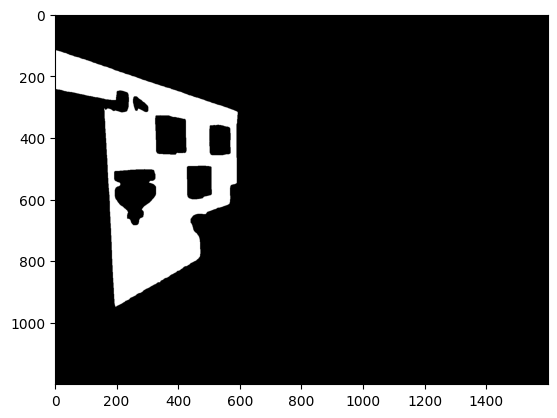

In [155]:
# erode = cv2.erode(mask, (5, 5), iterations = 10)
# plt.imshow(erode)

# morph = cv2.morphologyEx(mask, cv2.MORPH_OPEN, (5, 5), iterations=10)
# plt.imshow(morph)

# dil = cv2.dilate(erode, (5,5), iterations = 10)
# plt.imshow(dil)

In [4]:
%pip install rdp

Note: you may need to restart the kernel to use updated packages.


In [105]:
from rdp import rdp
def find_peak_points(mask):
    msk = mask.copy()
    edge=cv2.Canny(msk, 30, 20)
    contours, hierarchy = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # res = cv2.drawContours(msk, contours, -1, (0, 255, 0), 3)
    # plt.imshow(res)
    
    ## separating the mask outline from all other unwanted contours
    outline = contours[0]
    for i in contours[1:]:
        if outline.shape[0] < i.shape[0]:
            outline = i
    print(outline.shape)
    
    ## finding the peak points using the Douglas-Peucker algorithm
    pp=rdp(outline, epsilon=75)
    tmp = mask.copy()
    for i in pp:
        tmp = cv2.circle(tmp, i[0], 3, (0, 255, 0), 3)
    plt.imshow(tmp)
    
    return pp

from scipy.spatial import distance as dist
def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="int")

def remove_dup_pts(pp):
    ind = list(np.lexsort((pp[:, 0], pp[:, 1])))
    res = []
    for i in ind[:-1]:
        new_pp = []
        new_pp.append(list(pp[i]))
        for j in ind[1:]:
            if abs(pp[i,0]-pp[j,0]) > 5 or abs(pp[i,1]-pp[j,1]) > 5:
                new_pp.append(list(pp[j]))
        # print([list(pp[i]) for i in ind])
        res.append(new_pp)
    return res

(4999, 1, 2)
15


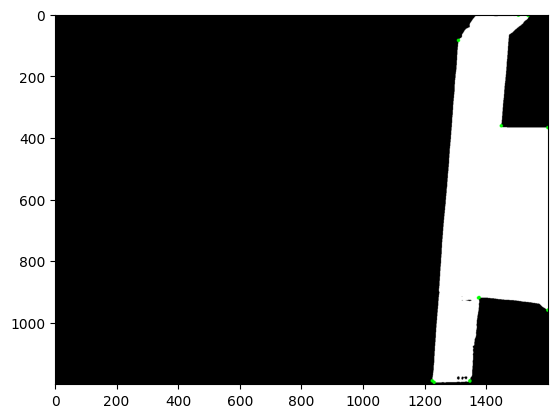

In [12]:
peak_pts = find_peak_points(all_masks[3]).reshape([-1, 2])
print(len(peak_pts))

In [106]:
ind = list(np.lexsort((peak_pts[:, 0], peak_pts[:, 1])))
for i in ind:
    print(peak_pts[i])

[1503    3]
[1504    3]
[1535    4]
[1309   85]
[1309   85]
[1448  362]
[1448  362]
[1599  368]
[1376  919]
[1374  920]
[1599  960]
[1224 1189]
[1346 1189]
[1346 1190]
[1230 1194]


In [103]:
new_pp = remove_dup_pts(peak_pts)

In [104]:
new_pp

[[[1503, 3],
  [1535, 4],
  [1309, 85],
  [1309, 85],
  [1448, 362],
  [1448, 362],
  [1599, 368],
  [1376, 919],
  [1374, 920],
  [1599, 960],
  [1224, 1189],
  [1346, 1189],
  [1346, 1190],
  [1230, 1194]],
 [[1504, 3],
  [1535, 4],
  [1309, 85],
  [1309, 85],
  [1448, 362],
  [1448, 362],
  [1599, 368],
  [1376, 919],
  [1374, 920],
  [1599, 960],
  [1224, 1189],
  [1346, 1189],
  [1346, 1190],
  [1230, 1194]],
 [[1535, 4],
  [1504, 3],
  [1309, 85],
  [1309, 85],
  [1448, 362],
  [1448, 362],
  [1599, 368],
  [1376, 919],
  [1374, 920],
  [1599, 960],
  [1224, 1189],
  [1346, 1189],
  [1346, 1190],
  [1230, 1194]],
 [[1309, 85],
  [1504, 3],
  [1535, 4],
  [1448, 362],
  [1448, 362],
  [1599, 368],
  [1376, 919],
  [1374, 920],
  [1599, 960],
  [1224, 1189],
  [1346, 1189],
  [1346, 1190],
  [1230, 1194]],
 [[1309, 85],
  [1504, 3],
  [1535, 4],
  [1448, 362],
  [1448, 362],
  [1599, 368],
  [1376, 919],
  [1374, 920],
  [1599, 960],
  [1224, 1189],
  [1346, 1189],
  [1346, 1190],


In [100]:
new_pp = np.array(new_pp)
np.unique(new_pp, axis = 0)

array([[1224, 1189],
       [1230, 1194],
       [1309,   85],
       [1346, 1189],
       [1346, 1190],
       [1374,  920],
       [1376,  919],
       [1448,  362],
       [1503,    3],
       [1504,    3],
       [1535,    4],
       [1599,  368],
       [1599,  960]], dtype=int32)

In [6]:
x = np.array([[1503,    3],
            [1230, 1194],
       [1346, 1190],
       [1376,  919],
      ])

In [7]:
order_points(x)

array([[1346, 1190],
       [1376,  919],
       [1503,    3],
       [1230, 1194]])